## A neural network from scratch using only numpy

Written by Joel Foo (2023).

In [1]:
import numpy as np

In [2]:
# activation functions
def relu(z, derivative=False):
    if derivative:
        # z < 0 => 0; z >=0 => 1
        return np.greater(z, 0).astype(int)
    return np.maximum(z, 0)

def sigmoid(z, derivative=False):
    if derivative:
        return np.exp(-z)/np.square(1 + np.exp(-z))
    return 1/(1 + np.exp(-z))

def tanh(x, derivative=False):
    if derivative:
        return 1 - np.square(np.tanh(x))
    return np.tanh(x)

def linear(z, derivative=False):
    if derivative:
        return 1
    return z

In [3]:
# softmax activation for the final layer
# here, we do not require the derivative but provide it for reference
def softmax(z):
    # z is (no of examples, no. of classes) (n, k)
    # returns a (n, k) softmax output matrix
    max_z = np.max(z, 1).reshape(z.shape[0], 1)
    e_z = np.exp(z - max_z)
    # keepdims=True makes the sum be 2d
    return e_z / e_z.sum(axis = 1, keepdims=True)
    

# additional info
def softmax_derivative(z):
    # for derivative: if there are k classes, need to output a kxk matrix (jacobian)
    # k x k per training example, so we output (n, k, k) matrix.
    # dA_i x dZ_j, i,j<=k
    s = soft_max(z)
    # takes in a (k, ) softmax vector
    # outputs a (k, k) matrix -> columns are z1,...,zk; rows are a1,...,ak
    def computeJacobian_naive(s):
        k = s.shape[0]
        jacobian = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                if i == j:
                    jacobian[i][j] = s[i] * (1 - s[i])
                else:
                    jacobian[i][j] = -s[i] * s[j]
        return jacobian
    
    def computeJacobian_fast(s):
        # multiply s by s.T. let s be (k, 1) and s.T be (1, k)
        return np.diagflat(s) - s.reshape(-1,1)@s.reshape(1,-1)
    
    n = z.shape[0]
    k = z.shape[1]
    lst = []
    for i in range(n):
        lst.append(computeJacobian_fast(s[i]))
    return np.array(lst).reshape((n, k, k))

In [4]:
# loss functions
def binary_cross_entropy(o, y, derivative=False):
    if derivative:
        return (o - y) / (o * (1 - o))
    return -(y * np.log(o) + (1 - y) * np.log(1 - o))

def mse(o, y, derivative=False):
    if derivative:
        return o - y
    return 0.5 * (y - o)**2

#### Cross entropy loss function

- Loss function for a single example 

- If we have k classes, and y value for a particular example is class k, then y<sub>k</sub> = 1, and y<sub>j</sub> = 0 for j != k)

- This simplifies to just -log(p<sub>k</sub>)!

<div>
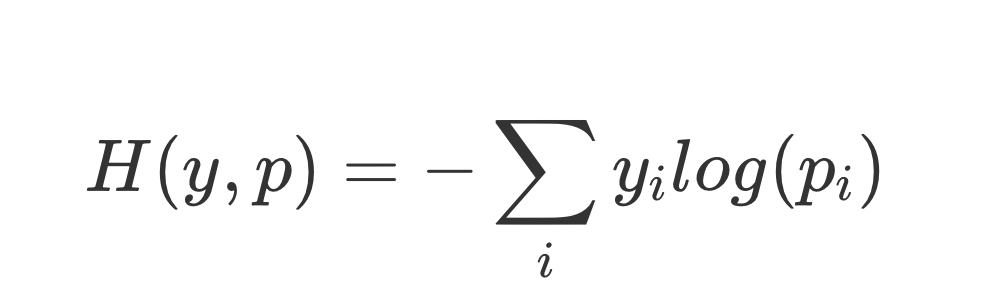
</div>

In [5]:
def cross_entropy_loss(s, y):
    # s is (no. of examples, no. of classes) (m, k)
    # y is one-hot encoded (m, k)
    m = y.shape[0]
    # convert to labels
    y = np.argmax(y, axis=1)
    p = s[range(m), y]
    
    # prevents np.log(0)
    epsilon = 1e-10
    
    return -np.log(p+1e-10)

In [6]:
class Layer:
    def __init__(self, num_units, activation):
        self.num_units = num_units
        self.activation = activation
        
        # shape of weight matrix: (num_inputs, num_units)
        # will fill this later when we init the NN
        self.W = np.array([])
        
        # init bias to 0 
        self.b = np.zeros((num_units,))
        
    def computeActivation(self, X):
        Z = X@self.W + self.b
        return Z, self.activation(Z)
    
    def computeDelta(self, z_s, activations, d_k1, prevLayer, prevZ):
        return np.multiply(d_k1@self.W.T, 
                                  prevLayer.activation(prevZ, derivative=True))

In [7]:
class NN:
    def __init__(self, num_features, layers, loss_fn):
        np.random.seed(42)
        layers[0].W = np.random.rand(num_features, layers[0].num_units)
        for i in range(1, len(layers)):
            layers[i].W = np.random.rand(layers[i - 1].num_units, layers[i].num_units)
        self.layers = layers
        self.loss_fn = loss_fn
        self.J_history = []
        self.lr = None
        
    # internal forward function
    def _forward(self, X):
        activation = X
        
        z_s = []
        activations = []
        activations.append(X)
        
        for layer in self.layers:
            z, activation = layer.computeActivation(activation)
            z_s.append(z)
            activations.append(activation)
            
        return z_s, activations, activation  
    
    # call this from outside
    def forward(self, X):
        activation = X
        for layer in self.layers:
            _, activation = layer.computeActivation(activation)
        return activation
    
    # computes dJ/dZ (delta_k or d_k) for each layer from the back and updates the layer parameters.
    def backprop(self, X, y):
        # forward pass
        z_s, activations, activation = self._forward(X)
        
        # compute cost
        self.J_history.append(self.loss_fn(activation, y).mean())
        
        # compute delta for final layer 
        
        # not softmax
        if self.loss_fn != cross_entropy_loss:
            # element wise multiplication
            d_k1 = self.loss_fn(activation, y, derivative=True)*self.layers[-1].activation(z_s[-1], derivative=True)
        
        # softmax (https://www.pinecone.io/learn/cross-entropy-loss/), we have a nice 
        # simplified formula for d_k1 (dJ/dz(r))
        else:
            d_k1 = activation - y
            
        # compute deltas for remaning layers
        for i in range(len(self.layers)-1, -1, -1):
            # take mean of gradients of the training examples
            # compute gradients based on d_k1
            dJ_dW = (activations[i].T@d_k1)/d_k1.shape[0]
            dJ_db = np.mean(d_k1, axis=0)
            
            # update params for layer+1
            self.layers[i].W -= self.lr * dJ_dW 
            self.layers[i].b -= self.lr * dJ_db
            
            # compute new d_k1
            if i != 0:
                d_k1 = self.layers[i].computeDelta(z_s, activations, d_k1, self.layers[i-1], z_s[i-1])
    
    def train(self, X, y, epochs, lr, batch_mtd='batch', batch_size=32):
        self.lr = lr
        self.epochs = epochs
        
        print(f"Training on {epochs} epochs with a learning rate of {lr}")
        
        for i in range(epochs):
            
            if batch_mtd == 'batch':
                self.backprop(X, y)
            
            elif batch_mtd == 'minibatch':
                m = X.shape[0]
                num_iters = (int)(np.ceil(m / batch_size))
                print(f"Running epoch {i + 1} of size {num_iters}...")
                
                # shuffle X
                arr = np.arange(m)
                np.random.shuffle(arr)
                
                for j in range(num_iters):
                    X_mini = X[arr[j * batch_size: (j+1) * batch_size]]
                    y_mini = y[arr[j * batch_size: (j+1) * batch_size]]
                    self.backprop(X_mini, y_mini)
                
                print(f"Completed epoch {i + 1}")
        

In [8]:
# XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([0,1,1,0]).reshape(-1,1)

nn = NN(num_features=X.shape[1], layers=[Layer(3, tanh), Layer(1, sigmoid)], loss_fn=binary_cross_entropy)

a = nn.forward(X)
print(a)

[[0.5       ]
 [0.56419606]
 [0.73829395]
 [0.76243156]]


In [9]:
nn.train(X, y, epochs=1500, lr=0.1)

Training on 1500 epochs with a learning rate of 0.1


In [10]:
# activations
nn.forward(X)

array([[0.03888014],
       [0.97249726],
       [0.96453346],
       [0.05113893]])

In [11]:
# pred accuracy
(nn.forward(X).round() == y).mean()

1.0

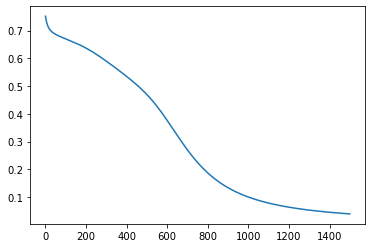

In [12]:
import matplotlib.pyplot as plt
plt.plot(list(range(nn.epochs)), nn.J_history)

In [13]:
# test softmax with 2 units (0, 1) -> results should be the same as the single sigmoid unit in
# the final layer

X = np.array([[0,0],[0,1],[1,0],[1,1]])

# one hot encoded
y = np.array([[1,0],[0,1],[0,1],[1,0]])

nn = NN(num_features=X.shape[1], layers=[Layer(4, tanh), Layer(2, softmax)], loss_fn=cross_entropy_loss)

a = nn.forward(X)
print(a)

[[0.5        0.5       ]
 [0.46789907 0.53210093]
 [0.41226397 0.58773603]
 [0.39956434 0.60043566]]


In [14]:
# we dont want scientific notations
np.set_printoptions(suppress=True)

nn.train(X, y, epochs=2000, lr=0.1)
nn.forward(X)

Training on 2000 epochs with a learning rate of 0.1


array([[0.99711982, 0.00288018],
       [0.00901517, 0.99098483],
       [0.01113854, 0.98886146],
       [0.98528955, 0.01471045]])

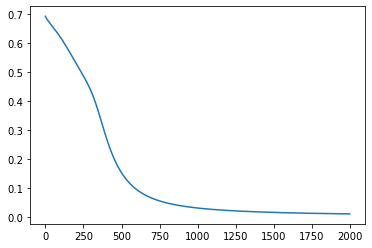

In [15]:
plt.plot(list(range(nn.epochs)), nn.J_history)

## Notes on backprop

(# ref: http://cs229.stanford.edu/notes2020spring/cs229-notes-deep_learning.pdf)

The algorithm in the picture below applies when all the hidden layers use ReLU and the final layer uses linear activation. 

As such, to make it more general, we have modified the following

- Step 2: delta[r] = (z[r] - o) * activation'(z[r])
- Step 2: J (cost function) used here is the MSE. Use cross entropy for logistic ouptuts -> which means definition of 2 needs to be modified.
- Step 4: instead of RELU', replace it with activation'


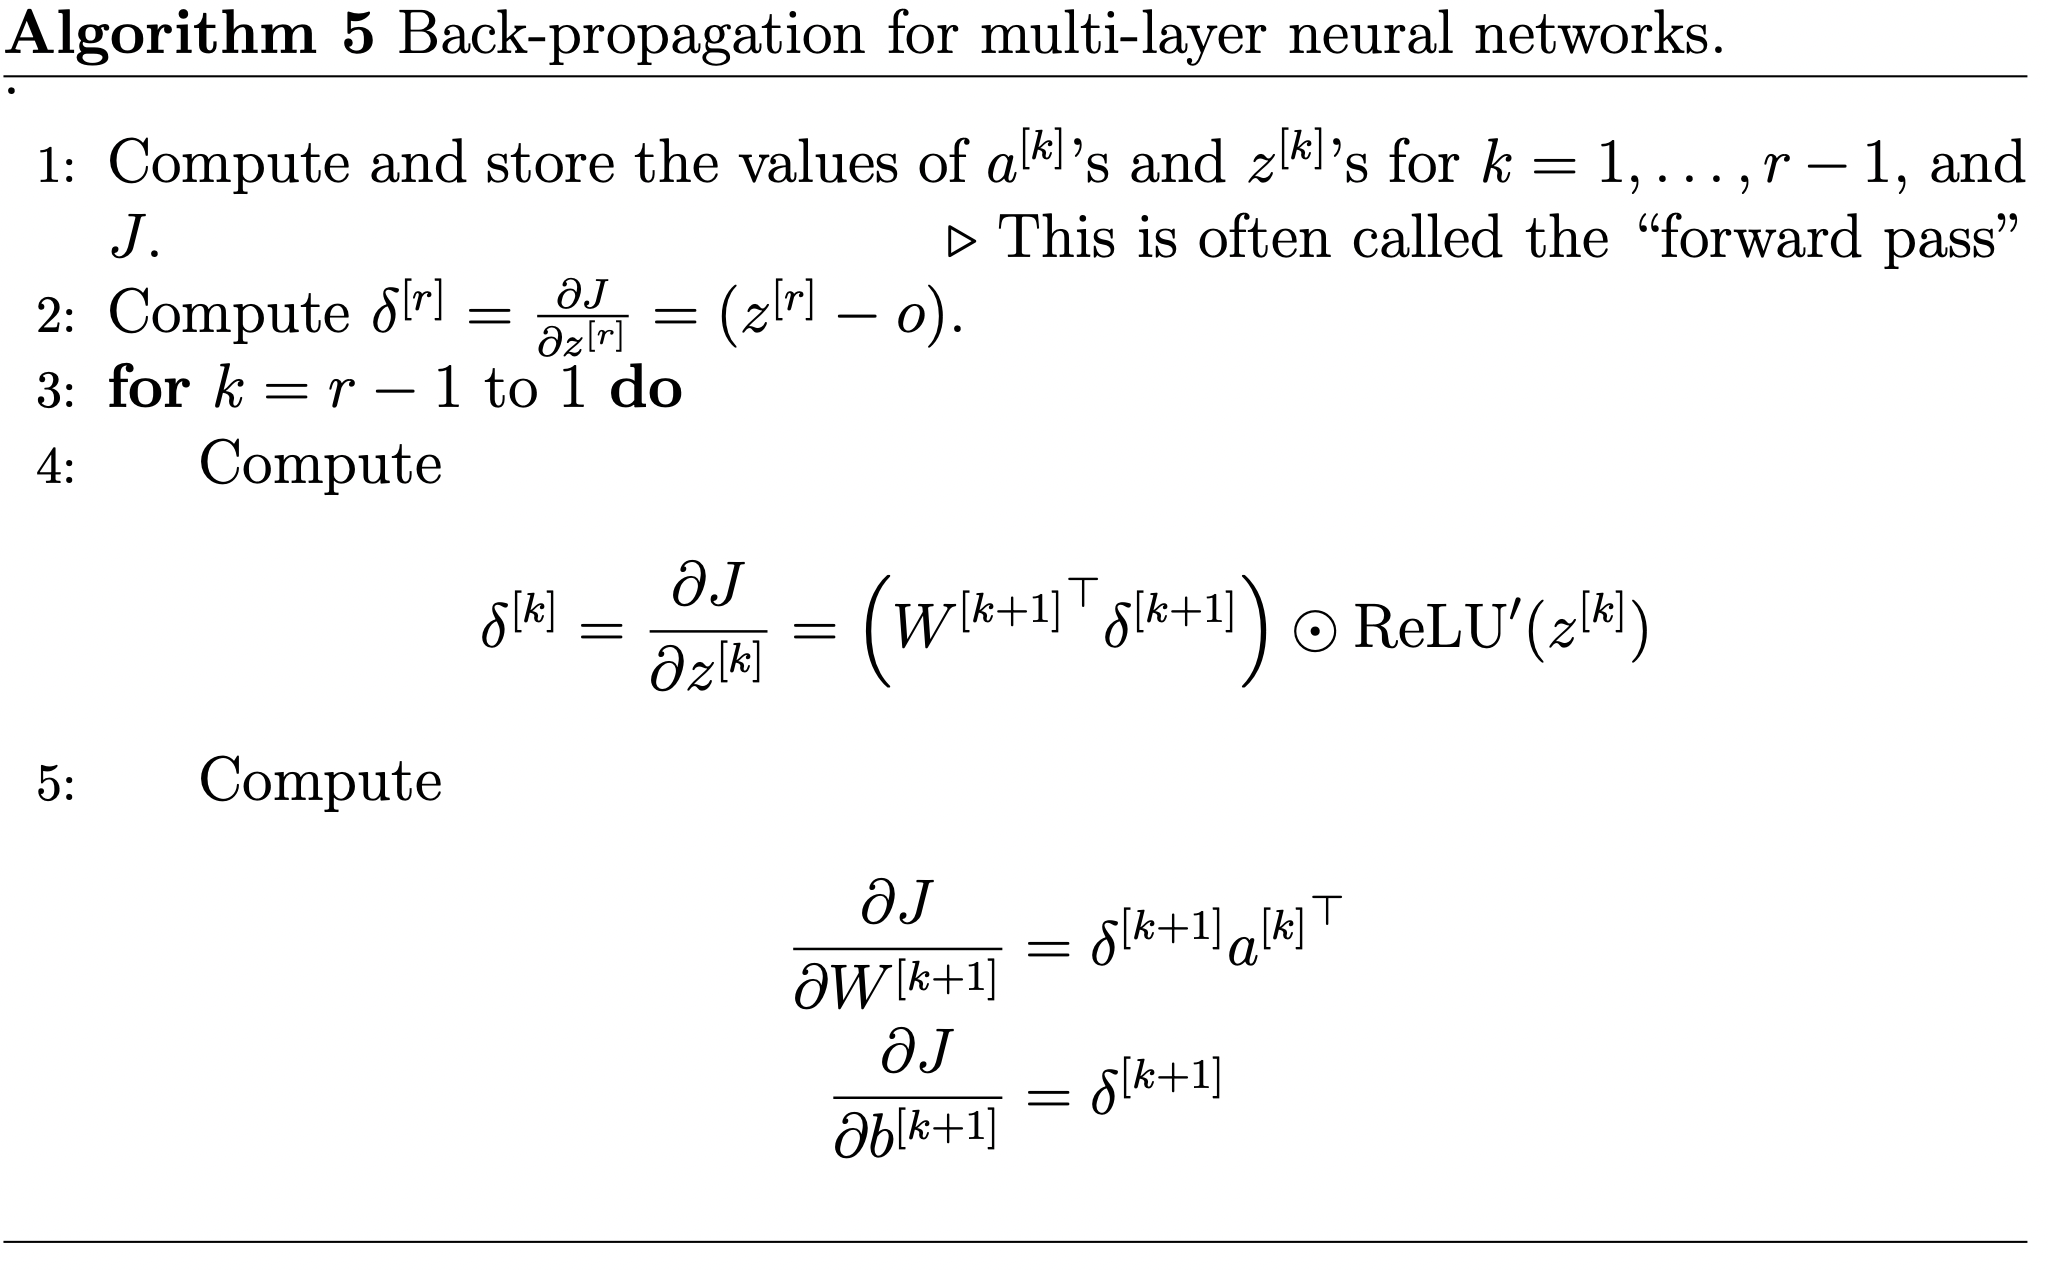

## * Benchmark using MINST *

In [16]:
import keras
from keras.datasets import mnist

In [17]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [18]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [19]:
# flatten 28 x 28 into 784 1d
x_train[0].flatten().shape

(784,)

In [20]:
num_classes = 10
# feature scaling (max val is 255)
X = x_train.reshape(x_train.shape[0],-1)/255.0
y = np.eye(num_classes)[y_train]

# hyperparams taken from https://www.tensorflow.org/datasets/keras_example, but we use minibatch=32 here
nn = NN(num_features=X.shape[1], layers=[Layer(128, relu), Layer(10, softmax)], loss_fn=cross_entropy_loss)

a = nn.forward(X)
print(a)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
# must use minibatch
nn.train(X, y, epochs=8, lr=0.001, batch_mtd='minibatch')

Training on 8 epochs with a learning rate of 0.001
Running epoch 1 of size 1875...
Completed epoch 1
Running epoch 2 of size 1875...
Completed epoch 2
Running epoch 3 of size 1875...
Completed epoch 3
Running epoch 4 of size 1875...
Completed epoch 4
Running epoch 5 of size 1875...
Completed epoch 5
Running epoch 6 of size 1875...
Completed epoch 6
Running epoch 7 of size 1875...
Completed epoch 7
Running epoch 8 of size 1875...
Completed epoch 8


In [22]:
# train accuracy
a = nn.forward(X)
pred_train = a.argmax(axis = 1)
(pred_train == y_train).mean()

0.84525

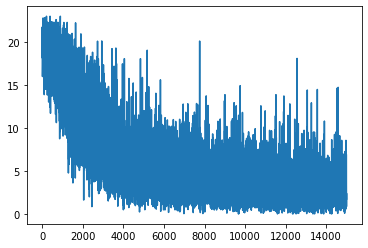

In [23]:
# as expected for minibatch (noisy)
plt.plot(nn.J_history)

In [24]:
# compute test accuracy
X2 = x_test.reshape(x_test.shape[0],-1)/255.0
y2 = np.eye(num_classes)[y_test]
a2 = nn.forward(X2)
pred_test = a2.argmax(axis = 1)
(pred_test == y_test).mean()

0.8548

In [25]:
# accuracy is good, no overfitting

In [26]:
# see some of the classified images
correct_classified = np.random.choice(np.where(pred_test == y_test)[0], size=16)
correct_classified

array([4812, 1730, 5842,  292, 3175, 9766, 1133, 1656, 8437, 2981, 1255,
       9843, 2482, 1306, 3002, 6438])

In [27]:
# see some of the misclassified images
misclassified = np.random.choice(np.where(pred_test != y_test)[0], size=8)
misclassified

array([3349, 3164, 6324, 9883,   18, 2436, 4044, 6910])

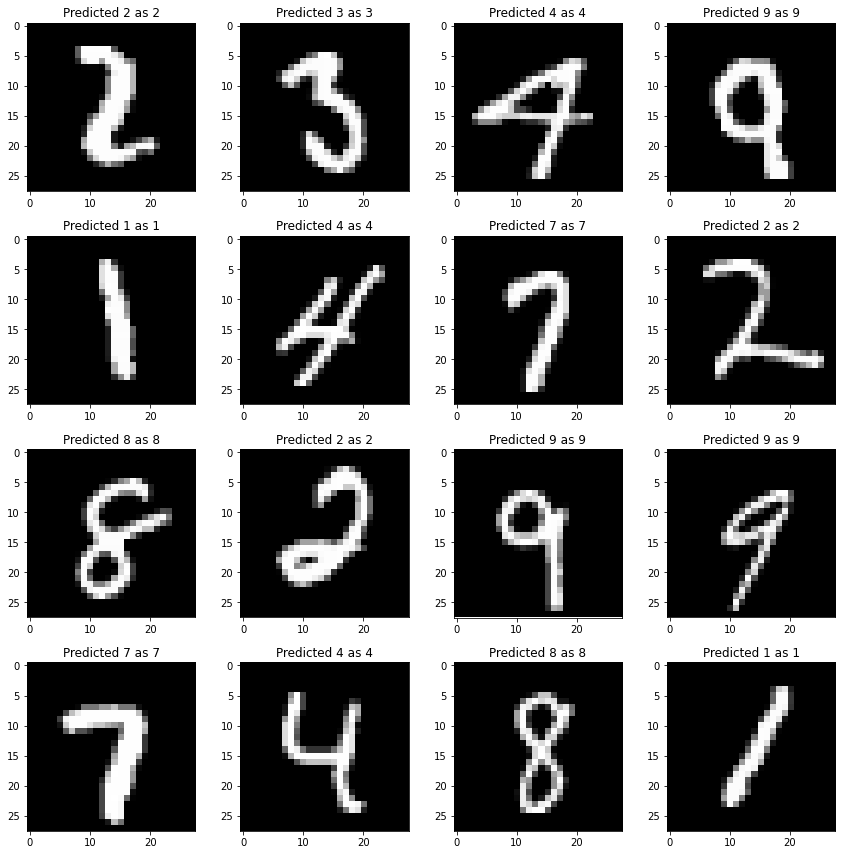

In [28]:
_, axs = plt.subplots(4, 4, figsize=(12,12))
plt.tight_layout()
axs = axs.flatten()
for i, ax in zip(correct_classified, axs):
    ax.imshow(x_test[i], cmap=plt.get_cmap('gray'))
    ax.set_title(f"Predicted {y_test[i]} as {pred_test[i]}")
plt.show()

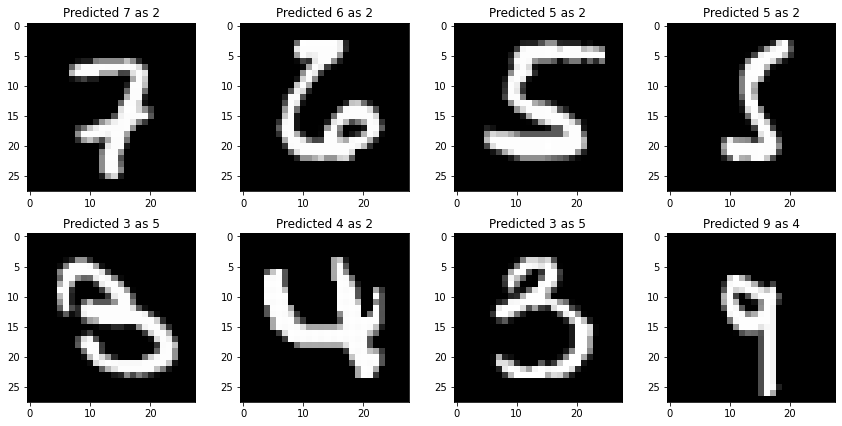

In [29]:
_, axs = plt.subplots(2,4, figsize=(12,6))
plt.tight_layout()
axs = axs.flatten()
for i, ax in zip(misclassified, axs):
    ax.imshow(x_test[i], cmap=plt.get_cmap('gray'))
    ax.set_title(f"Predicted {y_test[i]} as {pred_test[i]}")
plt.show()